In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap 

import causalml
from causalml.metrics import plot_gain, plot_qini, qini_score
from causalml.dataset import synthetic_data
from causalml.inference.tree import plot_dist_tree_leaves_values, get_tree_leaves_mask
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor
from causalml.inference.tree.utils import timeit

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('../../data/acoustic_and_session.csv')

In [3]:
cols1 = [ 'hour_of_day', 'session_position', 'premium', 'session_length','hist_user_behavior_is_shuffle', 'custom_skip',
 'duration', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'valence'] 
df["mode"] = df.apply(lambda x:1 if x["mode"]=="major"else 0, axis = 1)

df1 = df[cols1]
for col in cols1:
    if df[col].dtype ==bool:
      df1[col] = df1[col].astype(int)
df1.rename(columns={'hist_user_behavior_is_shuffle':'shuffle'},inplace =True)



In [4]:
df_train, df_test = train_test_split(df1, test_size=0.2, random_state=111)

In [5]:
feature_names = [ 'hour_of_day', 'session_position', 'session_length',
   'us_popularity_estimate','duration','shuffle',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'premium',
       'tempo', 'valence'] 
treatment = ['speechiness']

In [6]:
X_train, y_train = df_train[feature_names], df_train['custom_skip'].values
X_test, y_test = df_test[feature_names], df_test['custom_skip'].values
treatment_train, treatment_test = df_train[treatment].values.flatten(), df_test[treatment].values.flatten()

In [7]:
treatment_train

array([0.16480528, 0.03847597, 0.03261309, ..., 0.28916833, 0.12731907,
       0.02784123])

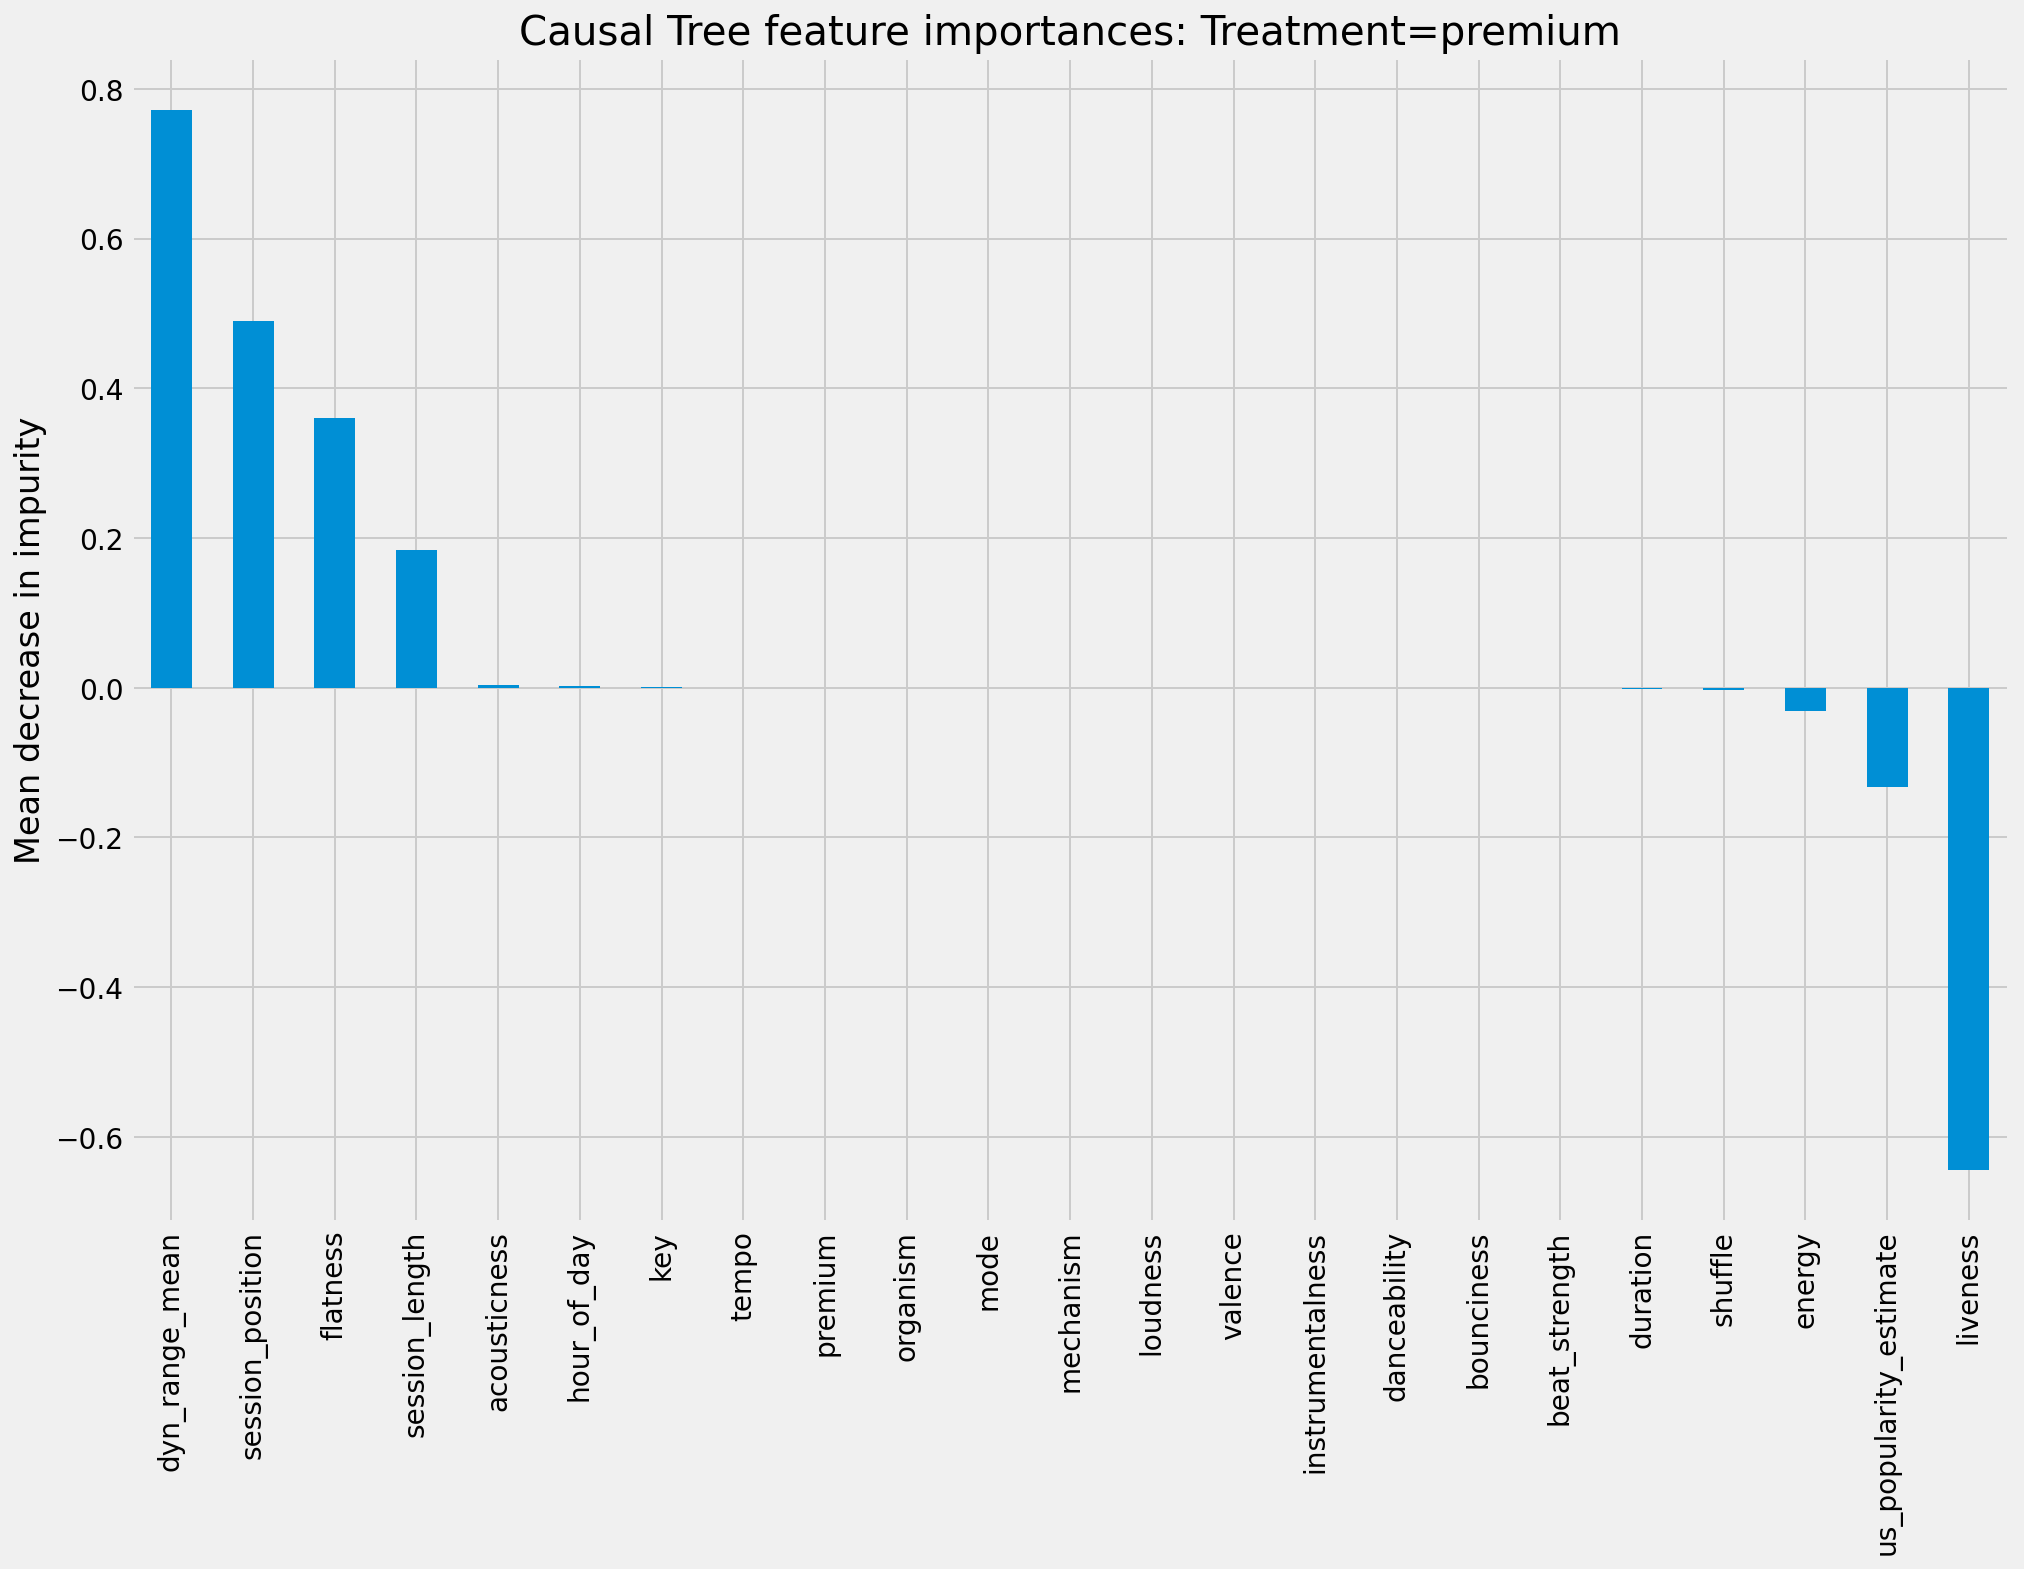

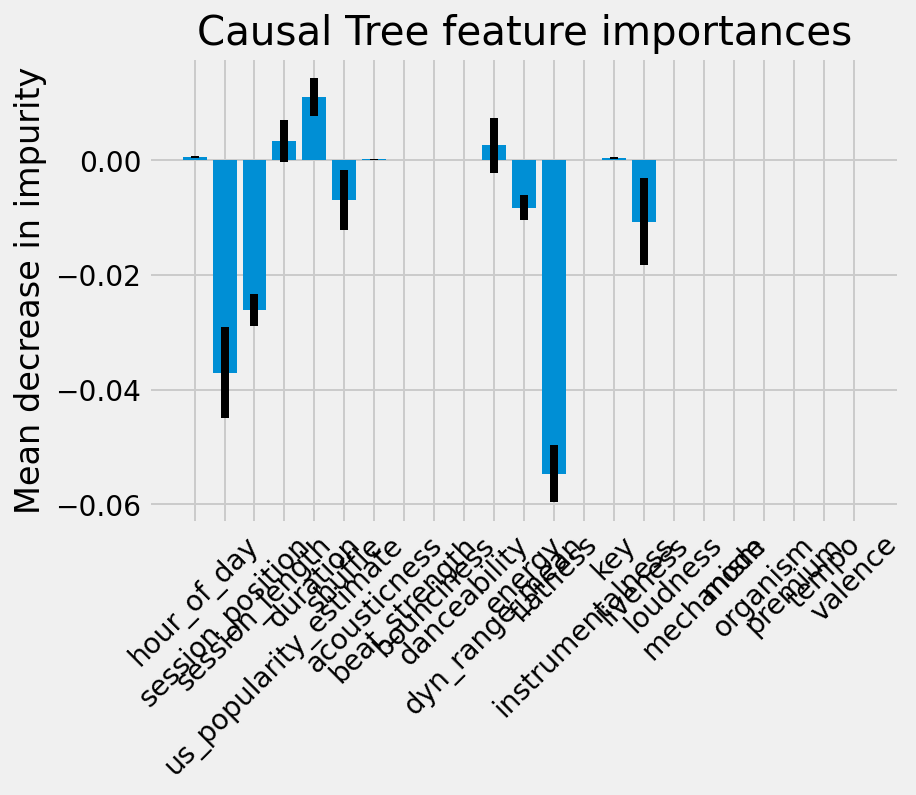

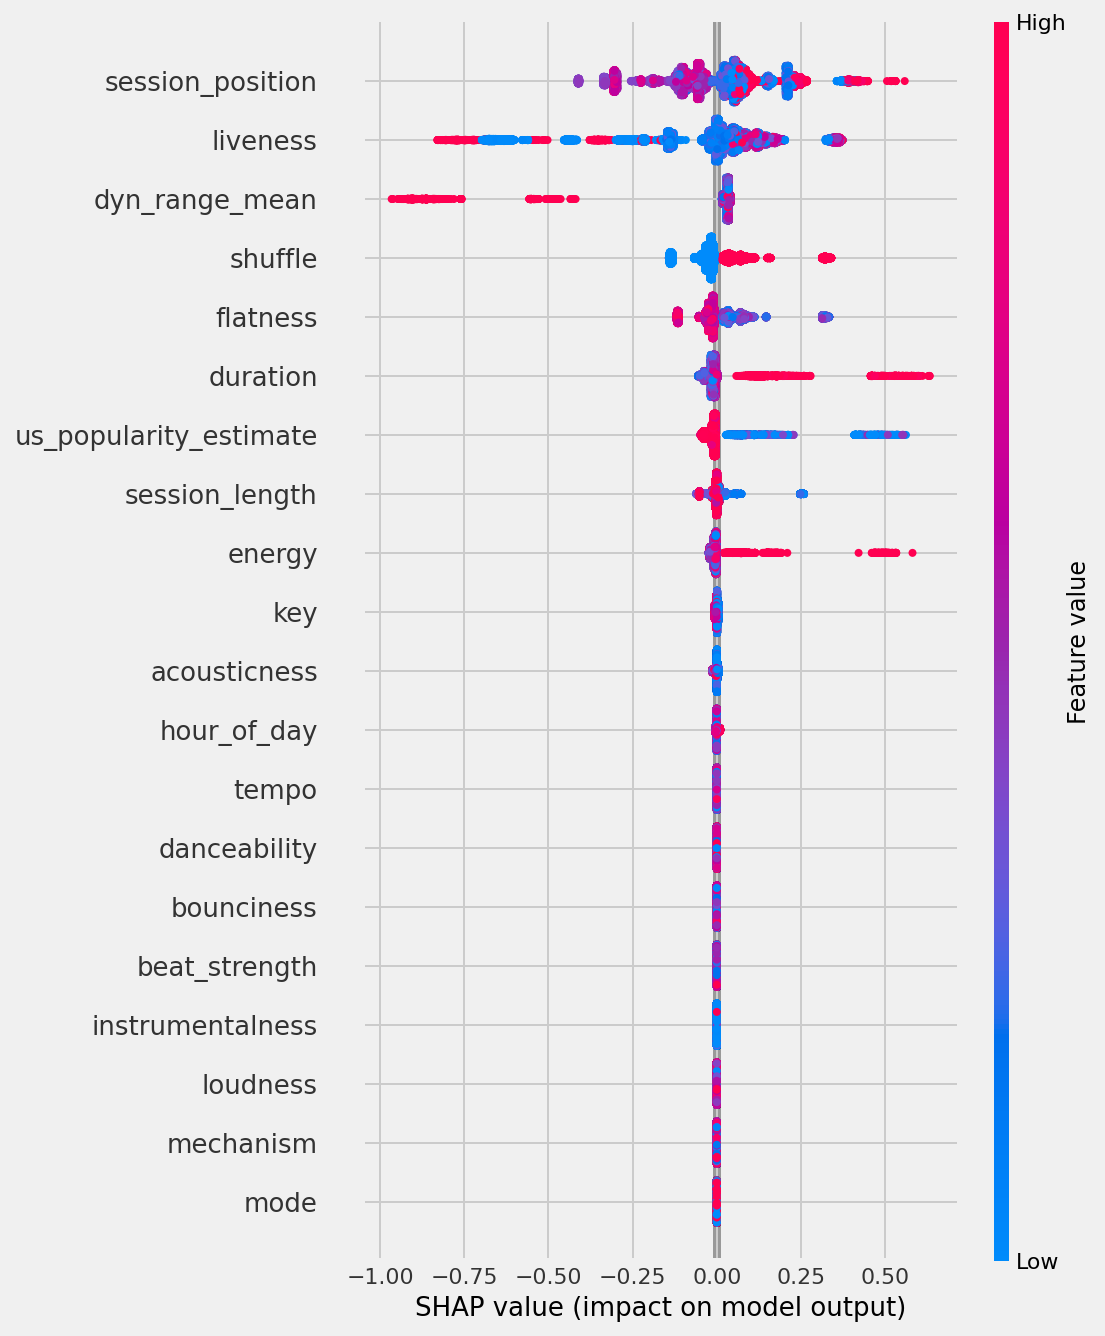

Text(0, 0.5, 'Treatment Effect')

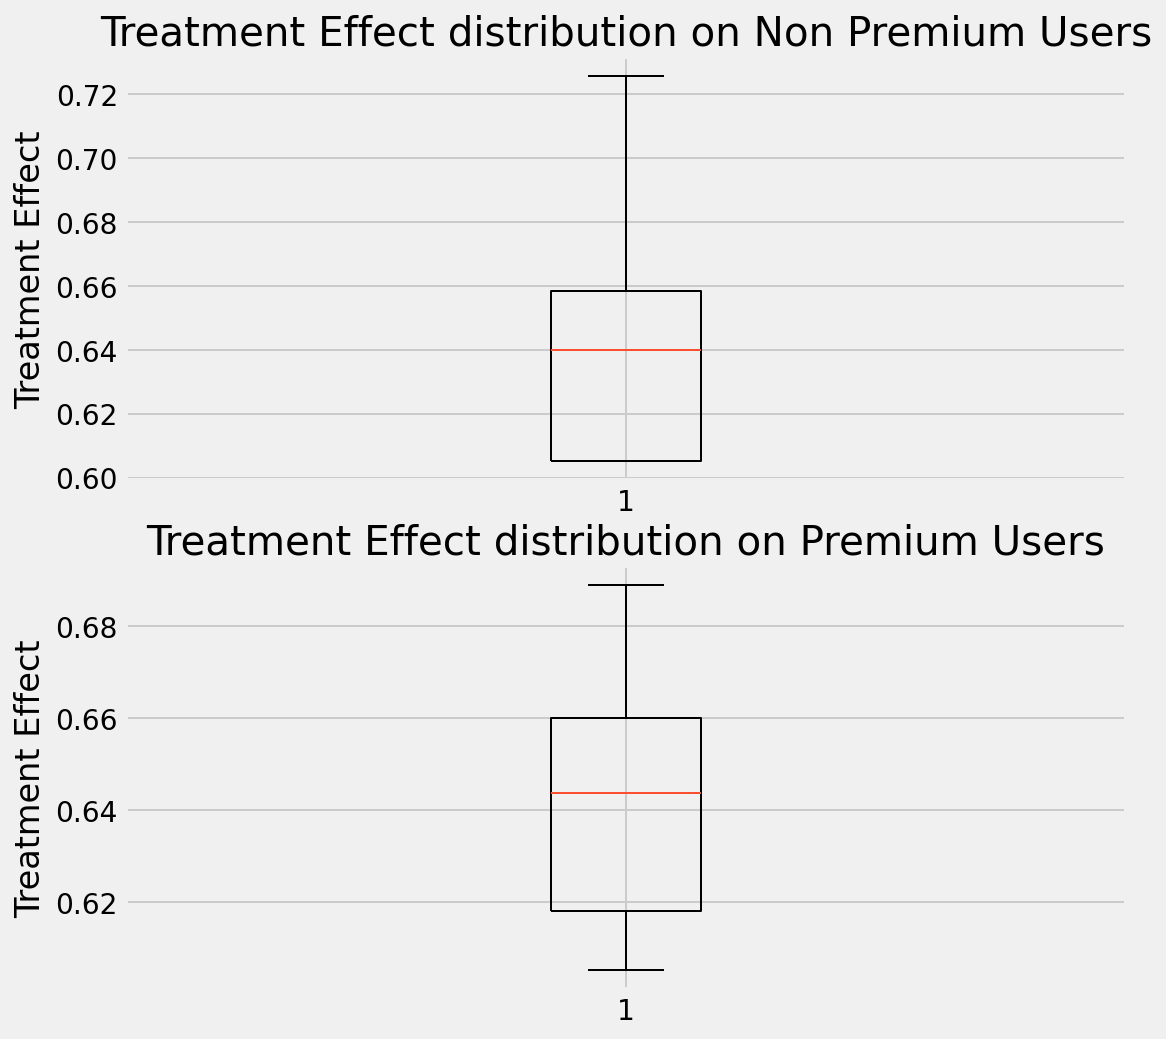

In [8]:
ctree = CausalTreeRegressor(control_name=0)
ctree.fit(X=X_train.values, y=y_train, treatment=treatment_train)
# crforest = CausalRandomForestRegressor(criterion="causal_mse",
#                                   min_samples_leaf=200,
#                                   control_name=0,
#                                   n_estimators=10,
#                                   n_jobs=mp.cpu_count() - 1)
# crforest.fit(X=X_train.values, y=y_train, treatment=treatment_train)
df_importances = pd.DataFrame({'tree': ctree.feature_importances_, 
                            #    'forest': crforest.feature_importances_,
                               'feature': feature_names
                              }).sort_values(by = ["tree"], ascending=False)
#forest_std = np.std([tree.feature_importances_ for tree in crforest.estimators_], axis=0)


ax = df_importances["tree"].plot.bar(figsize=(15, 10), title = "Causal Tree feature importances: Treatment=premium",
ylabel ="Mean decrease in impurity" )

ax.set_xticklabels(df_importances.feature, rotation=90)
plt.show()

# fig, ax = plt.subplots()
# df_importances['forest'].plot.bar(yerr=forest_std, ax=ax)
# ax.set_title("Causal Forest feature importances")
# ax.set_ylabel("Mean decrease in impurity")
# ax.set_xticklabels(feature_names, rotation=45)
# plt.show()
df_importances
ctree.feature_importances_
name, model ='Causal Tree', ctree
    
imp = permutation_importance(model, X_test, y_test,
                                n_repeats=50,
                                random_state=0)

fig, ax = plt.subplots()
ax.set_title(f"{name} feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.bar(feature_names, imp['importances_mean'], yerr=imp['importances_std'])
ax.set_xticklabels(feature_names, rotation=45)
plt.show()
shap.initjs()
observation = X_test.iloc[0]
tree_explainer = shap.TreeExplainer(ctree)
shap_values = tree_explainer.shap_values(observation)
shap.force_plot(tree_explainer.expected_value[0],
                shap_values,
                observation)
shap.summary_plot(tree_explainer.shap_values(X_test), X_test)
tree1_ite_pred = ctree.predict(df_test[feature_names].values)
tree1_ite_pred
tree1_ite_pred.mean()
df_result = pd.DataFrame({"ite":tree1_ite_pred, "premium": df_test["premium"].values})
df_result
f, axs = plt.subplots(2,1,figsize=(8,8))
axs[0].boxplot(df_result[df_result["premium"]==0]['ite'], showfliers=False)
axs[0].set_title('Treatment Effect distribution on Non Premium Users')
axs[0].set_ylabel('Treatment Effect')
axs[1].boxplot(df_result[df_result["premium"]==1]['ite'], showfliers=False)
axs[1].set_title('Treatment Effect distribution on Premium Users')
axs[1].set_ylabel('Treatment Effect')


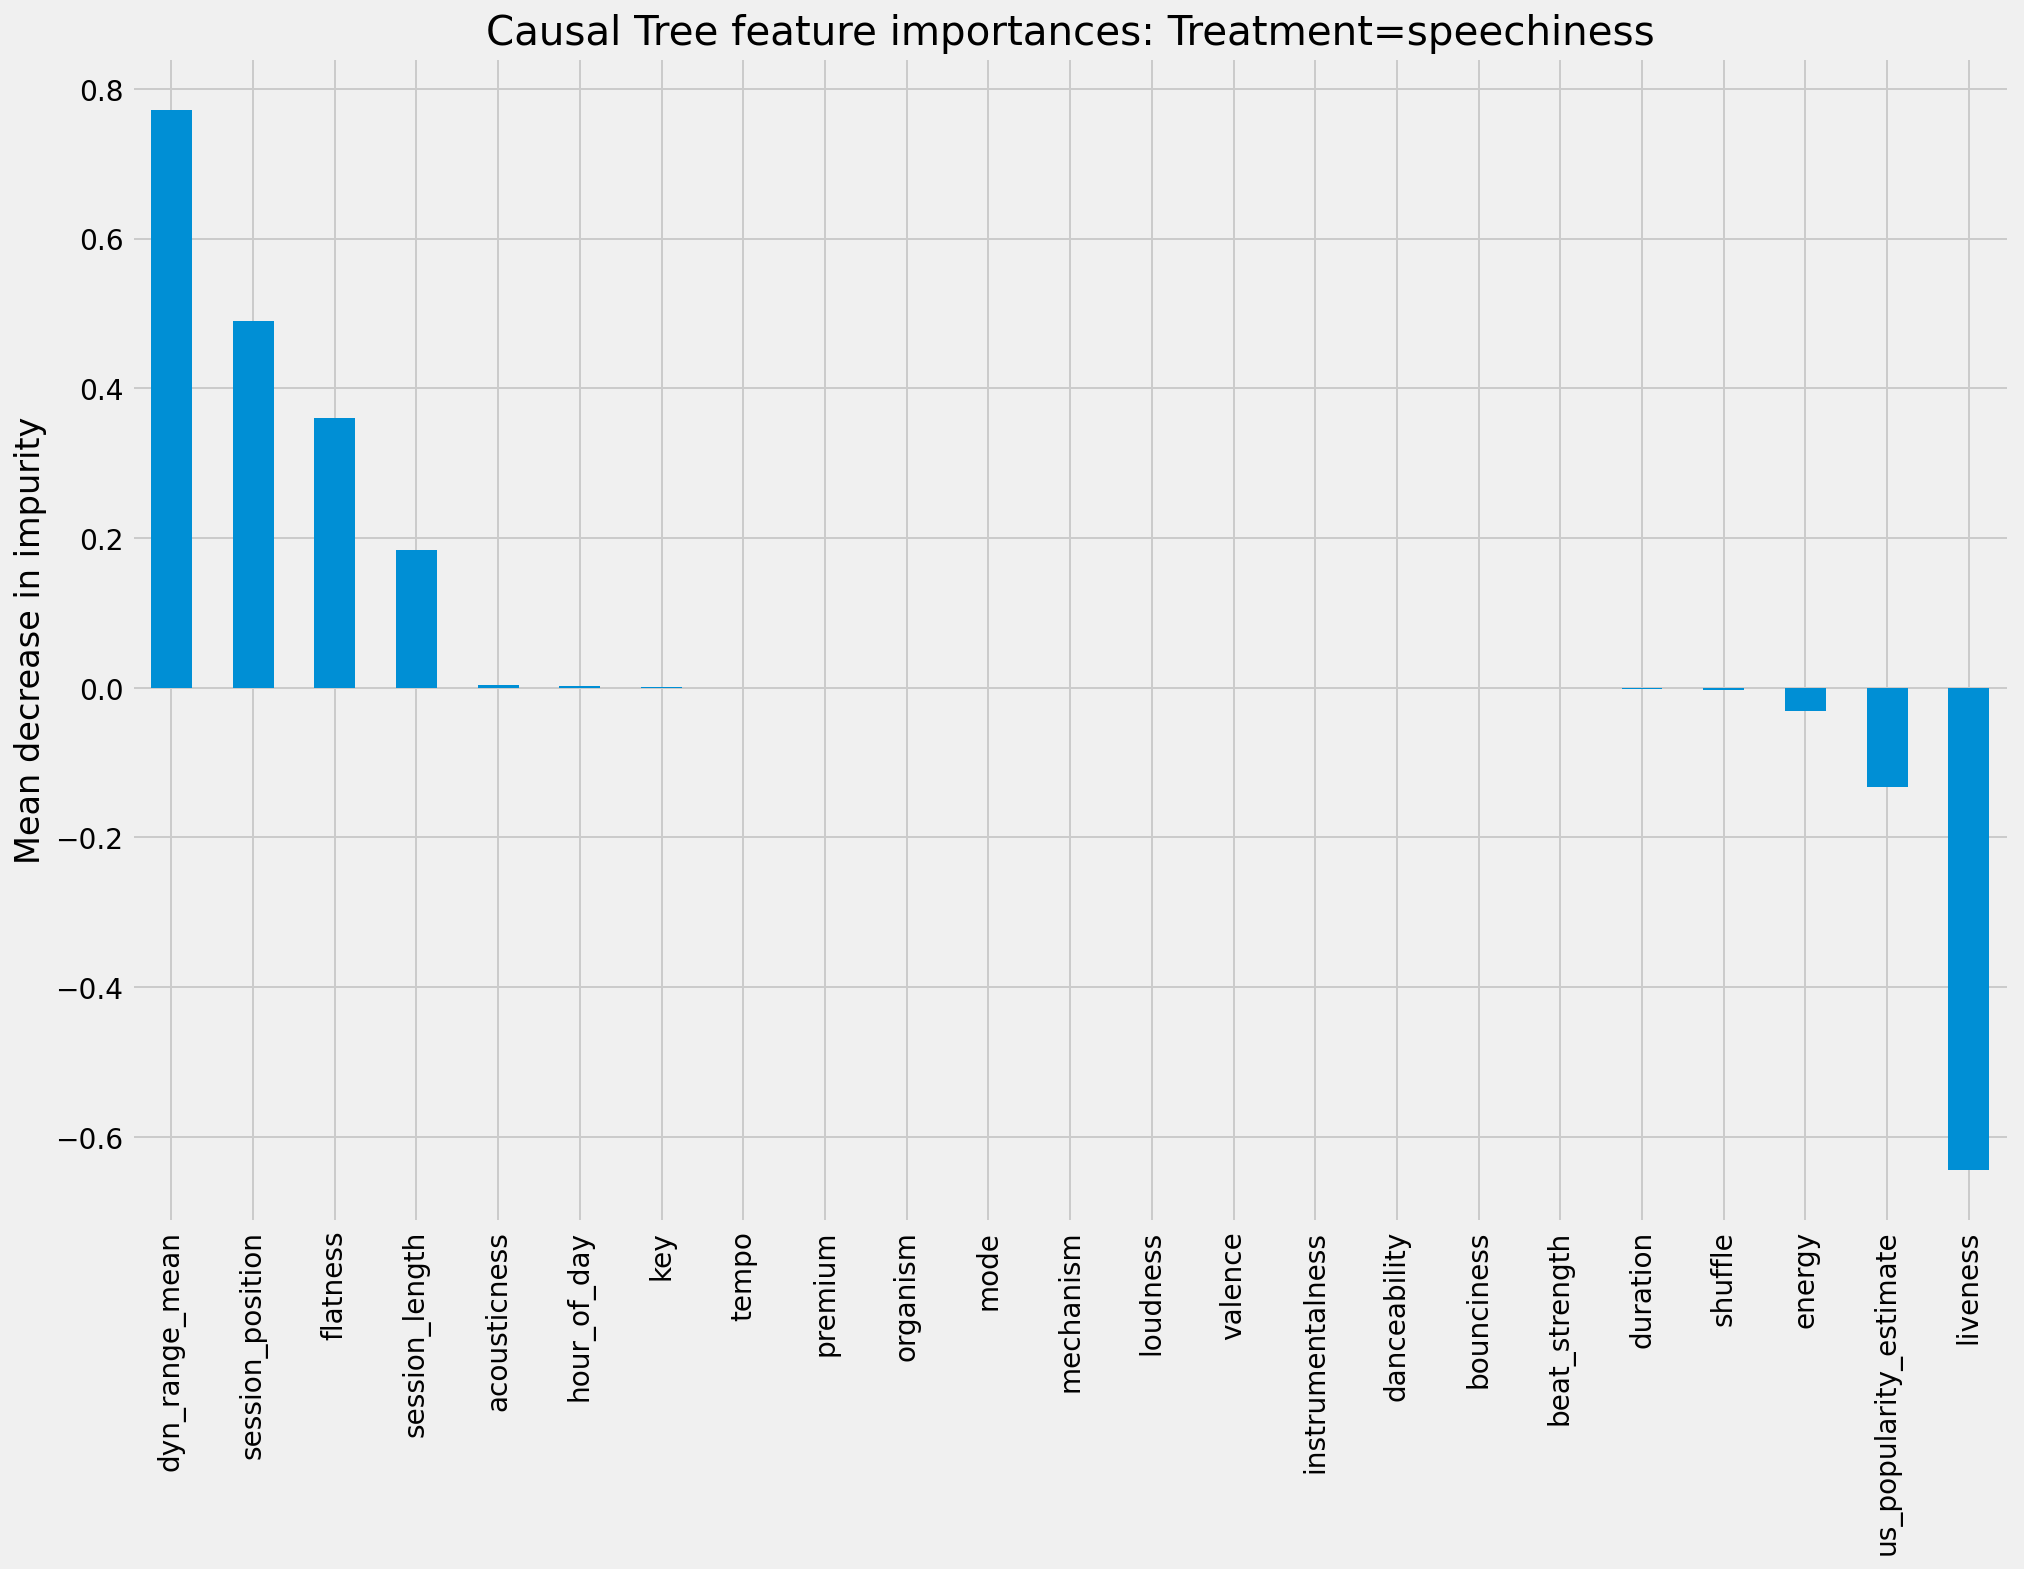

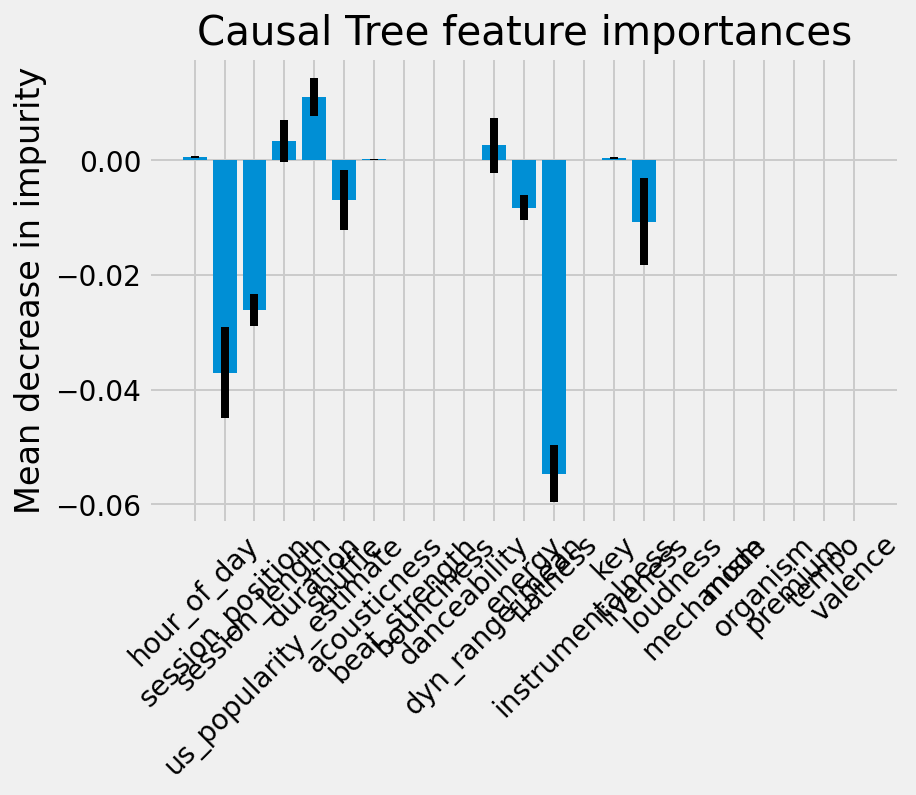

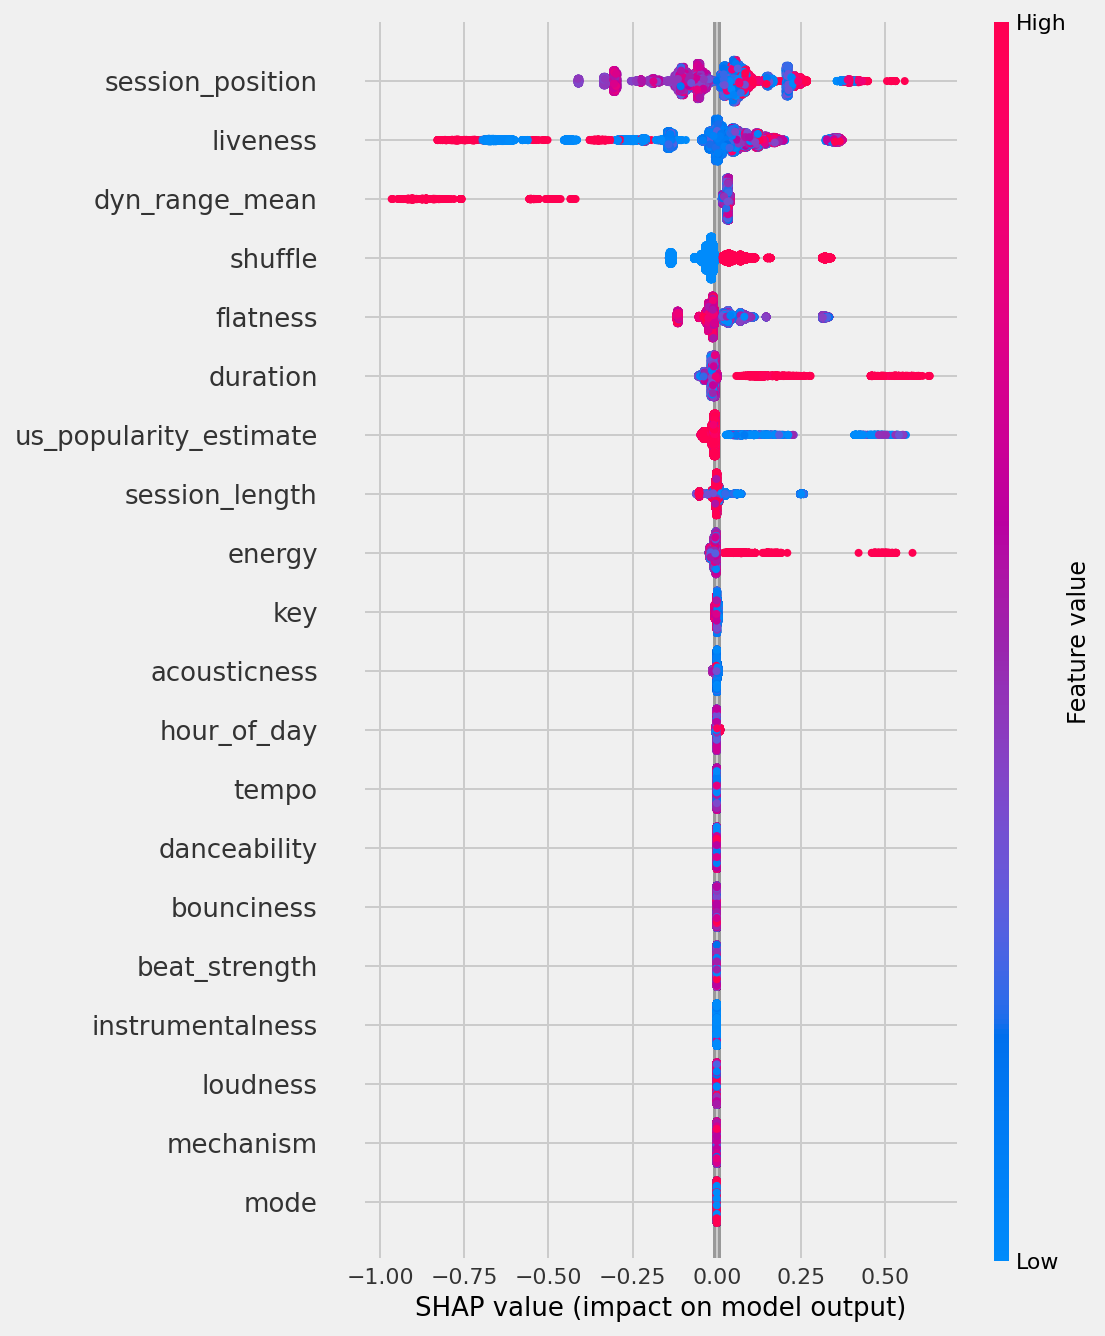

{'whiskers': [<matplotlib.lines.Line2D at 0x246dbe3e198>,
 'caps': [<matplotlib.lines.Line2D at 0x246dbe3e780>,
 'boxes': [<matplotlib.lines.Line2D at 0x246dbe3e0f0>],
 'medians': [<matplotlib.lines.Line2D at 0x246dbe3ed30>],
 'fliers': [],
 'means': []}

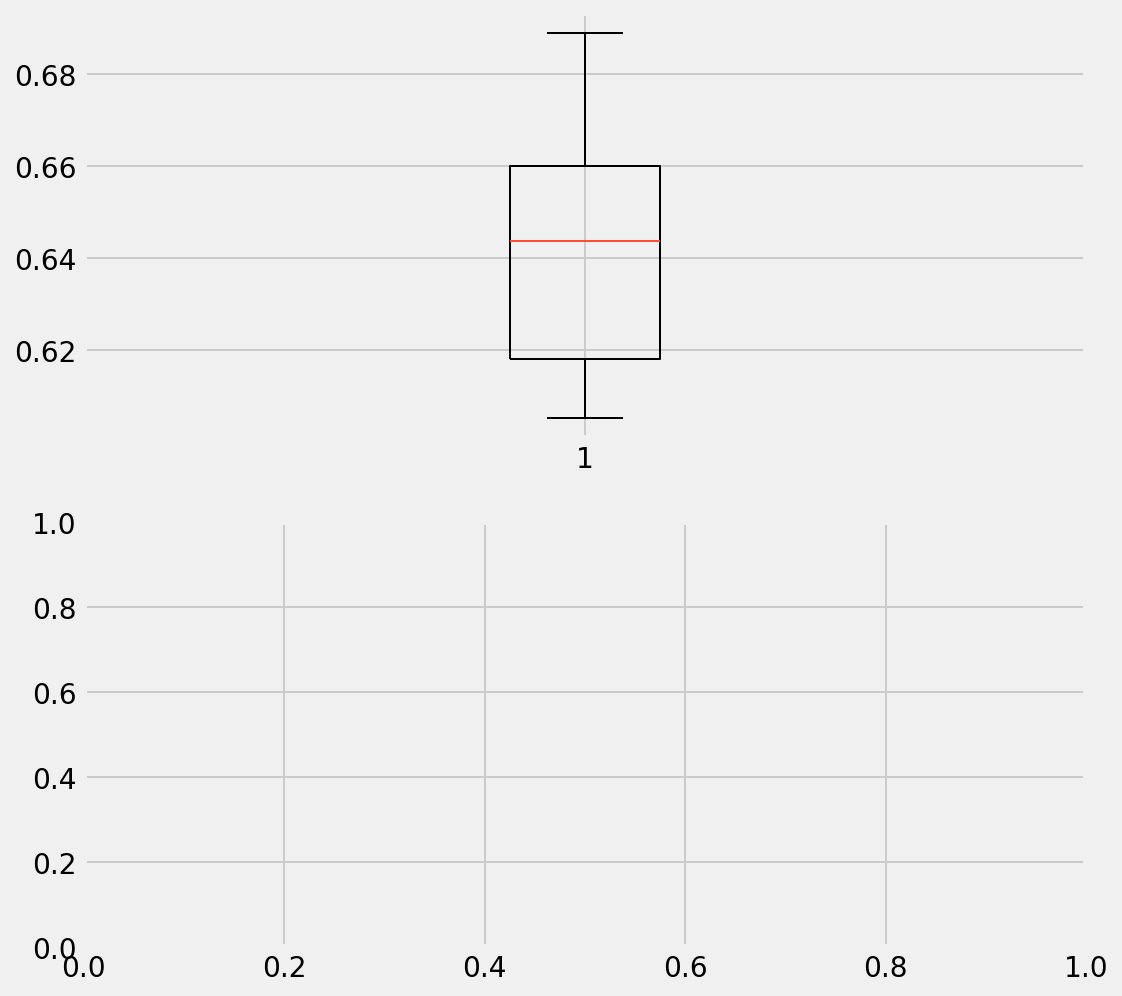

In [9]:

ax = df_importances["tree"].plot.bar(figsize=(15, 10), title = "Causal Tree feature importances: Treatment=speechiness",
ylabel ="Mean decrease in impurity" )

ax.set_xticklabels(df_importances.feature, rotation=90)
plt.show()

# fig, ax = plt.subplots()
# df_importances['forest'].plot.bar(yerr=forest_std, ax=ax)
# ax.set_title("Causal Forest feature importances")
# ax.set_ylabel("Mean decrease in impurity")
# ax.set_xticklabels(feature_names, rotation=45)
# plt.show()
df_importances
ctree.feature_importances_
name, model ='Causal Tree', ctree
    
imp = permutation_importance(model, X_test, y_test,
                                n_repeats=50,
                                random_state=0)

fig, ax = plt.subplots()
ax.set_title(f"{name} feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.bar(feature_names, imp['importances_mean'], yerr=imp['importances_std'])
ax.set_xticklabels(feature_names, rotation=45)
plt.show()
shap.initjs()
observation = X_test.iloc[0]
tree_explainer = shap.TreeExplainer(ctree)
shap_values = tree_explainer.shap_values(observation)
shap.force_plot(tree_explainer.expected_value[0],
                shap_values,
                observation)
shap.summary_plot(tree_explainer.shap_values(X_test), X_test)
tree1_ite_pred = ctree.predict(df_test[feature_names].values)
tree1_ite_pred
tree1_ite_pred.mean()
df_result = pd.DataFrame({"ite":tree1_ite_pred, "premium": df_test["premium"].values})
df_result
f, axs = plt.figure(2,1,figsize=(8,8))
axs[0].boxplot(df_result['ite'], showfliers=False)


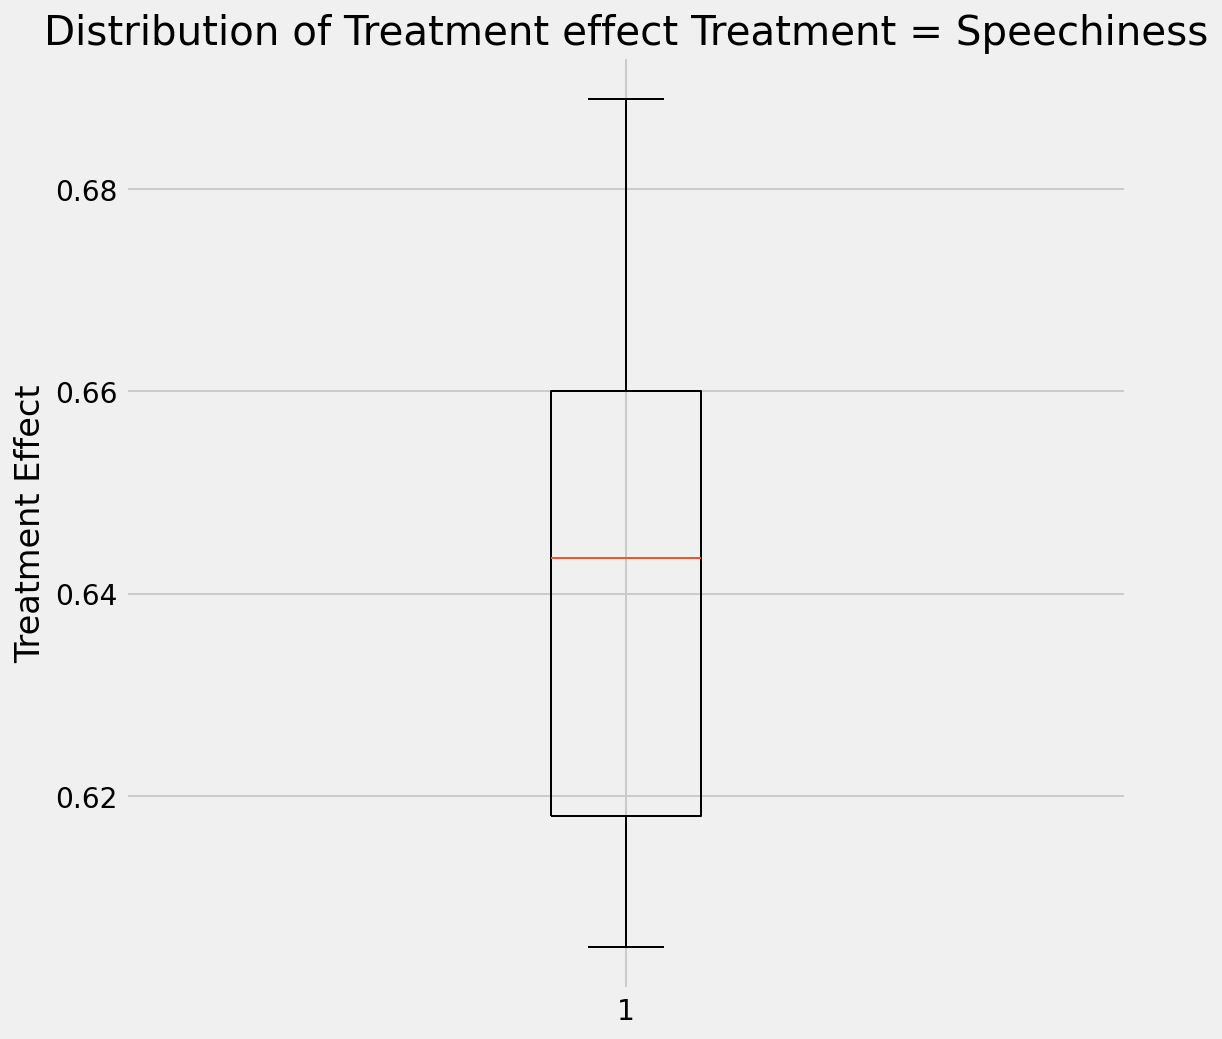

In [25]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)
ax.boxplot(df_result['ite'], showfliers=False)
ax.set_title("Distribution of Treatment effect Treatment = Speechiness")
ax.set_ylabel('Treatment Effect')
f.savefig("speechiness_ite.png")


In [22]:
plt.show()